Notebook set-up

In [142]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import os
import seaborn as sns
pd.options.mode.chained_assignment = None

Data Prep

In [143]:
# unzipping survey tables

# specifying location of .zip and extraction location
sur_C_path="/home/rthoms/ocean_dep/sur_C/raw_data/Sur_C_07062023.zip"
sur_C_raw="/home/rthoms/ocean_dep/sur_C/raw_data/sur_C_raw"

# loading the .zip and creating a zip object
with ZipFile(sur_C_path, 'r') as zObject:

	# Extracting all the members of the zip
	# into a the specified location.
	zObject.extractall(
		path=sur_C_raw)

# specifiying location of raw survey data
acs_raw = os.path.join(sur_C_raw, "Adapative_Capacity_Survey_0.csv")
df_main = pd.read_csv(acs_raw)

# specifiying location of raw practice data
prac_raw = os.path.join(sur_C_raw, "practice_table_1.csv")
df_prac = pd.read_csv(prac_raw) 
df_prac = df_prac.rename(columns={'ObjectID': 'objectid'})

# specifiying location of raw survey data
df_main_v2 = df_main.rename(columns={'globalid': 'ParentGlobalID'})

df_main_v2.drop(columns=['objectid','note', 'review_flag','CreationDate', 'Creator', 'EditDate', 'Editor', 'x', 'y'], inplace=True)

# merge the practice and the survey data
df_prac_joined = pd.merge(df_prac,df_main_v2,on='ParentGlobalID', how='outer')

In [144]:
dfs= [df_main, df_prac_joined]
for df in dfs:
    df.direction_change_seagrass = pd.Categorical(df.direction_change_seagrass, 
        categories=['sig_less','less','no_change','more','sig_more','unsure','NR'],
        ordered=True)
    

Defining visualizations

In [145]:
# create color pallet
colors = ['#4a6fe3', '#ef9708', '#8e063b', '#023fa5', 
         '#d33f6a','#0fcfc0', '#f79cd4', '#11c638', 
         '#8595e1', '#f0b98d', '#bb7784', '#7d87b9', 
         '#e07b91', '#9cded6', '#f6c4e1', '#8dd593']
colors = ['#FC6E51','#5D9CEC','#FFCE54','#A0D468',
         '#4FC1E9','#8067B7','#ED5565','#48CFAD',
         '#AC92EC','#EC87C0',  '#CCD1D9','#656D78',
         '#434A54']

In [146]:
#Define functions 

def disagg(df, viz_col, disagg_col):
    # count responses for question by disaggregate colum
    df_count= df.groupby([viz_col, disagg_col]).agg(count=('objectid', 'count')).reset_index()
    if prop == True:
        # count total survey responses by dissagregate colum
        df_tot= df.groupby(disagg_col).agg(total=('objectid', 'count')).reset_index()
        # merge response counts and total counts 
        df_join= pd.merge(df_count, df_tot, how="outer", on=disagg_col)
        # calculate proportion of responses of each dissagregate value
        df_join['prop'] = (df_join['count'] / df_join['total']).round(2)

        # drop columns and pivot table for visualization
        df_prop = df_join.drop(['count','total'], axis=1)
        df_viz = df_prop.pivot_table(index=[viz_col], columns=disagg_col, values="prop").reset_index()
    else:
        df_viz = df_count.pivot_table(index=[viz_col], columns=disagg_col, values="count").reset_index()
    return df_viz


def disagg_subplots(df, viz_col, plot_col,disagg_col):
    df_count= df.groupby([plot_col, viz_col, disagg_col]).agg(count=('objectid', 'count')).reset_index()
    if prop == True:
        df_tot= df.groupby([plot_col,disagg_col]).agg(total=('objectid', 'count')).reset_index()
        # merge response counts and total counts 
        df_join= pd.merge(df_count, df_tot, how="outer", on= [plot_col, disagg_col])
        # calculate proportion of responses of each dissagregate value
        df_join['prop'] = (df_join['count'] / df_join['total']).round(2)
        # drop columns and pivot table for visualization
        df_prop = df_join.drop(['count','total'], axis=1)
        df_viz = df_prop.pivot_table(index=[viz_col, plot_col ], columns=disagg_col, values="prop", fill_value=0).reset_index()
    else: 
        df_viz = df_count.pivot_table(index=[viz_col, plot_col ], columns=disagg_col, values="count", fill_value=0).reset_index()
    return df_viz

def nrowcol(plot_col):
    if plot_col == 'gear':
        nrows=2
        ncols=4
    elif plot_col == 'ccp':
        nrows=3
        ncols=4
    elif plot_col == 'gender':
        nrows = 1
        ncols = 2
    return nrows, ncols

def get_measure(prop):
    if prop == True:
        measure = "Proportion"
    elif prop == False:
        measure = "Count"
    return measure


def bar_plt(df_viz):
    # Sort data 
    df_viz.sort_values(viz_col, inplace=True)
    # get measurement
    measure = get_measure(prop)
    #plot
    plt.bar(df_viz.index, df_viz.values, color='#FC6E51')
    plt.ylabel(measure + ' of respondents')
    plt.show()

def bar_plt_group(df_viz,viz_col,disagg_col,bar_labels=False):
    # Sort data 
    df_viz.sort_values(viz_col, inplace=True)
    # Set index
    df_viz.set_index(viz_col, inplace=True)
    # get measurement
    measure = get_measure(prop)
    # plot chart
    ax = df_viz.plot(kind='bar', color=colors, figsize=(20, 8), rot=0, ylabel=measure +' of respondents by '+ disagg_col)
    if bar_labels == True:
        for c in ax.containers:
                ax.bar_label(c, fmt='%.2f', label_type='edge')
    plt.show()

def bar_plot_sub(df_viz, viz_col, plot_col):
    r,c= nrowcol(plot_col)
    # get measurement
    measure = get_measure(prop)
    fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(18, 8), sharex=True, sharey=True)
    fig.suptitle(viz_col, fontsize=18, y=1)
    plt.subplots_adjust(bottom=0.05, left =0.05, right=.95, top=0.92)
        
    for i, ax in enumerate(axs.flat):
        df_viz[df_viz.columns[i]].plot(kind='bar', color=colors[i], ax=ax)
        ax.set_title(df_viz.columns[i])
    fig.supylabel(measure + ' of survey respondents by ' + plot_col)
            
    plt.show()

def bar_plot_group_sub(df_viz, viz_col, plot_col, disagg_col):
    # reindex to fill in zeros
    plot_col_values = list(df_viz[plot_col].unique())
    viz_col_values = list(df_viz[viz_col].unique())
    levels = [viz_col_values, plot_col_values]
    df_viz.set_index([viz_col, plot_col], inplace=True) 
    new_index = pd.MultiIndex.from_product(levels, names=df_viz.index.names)
    df_viz = df_viz.reindex(new_index, fill_value=0)
            
    # reset index
    df_viz=df_viz.reset_index()

    #Set index for plotting
    df_viz.set_index(viz_col, inplace=True)
            
    # define subplot grid
    r,c=nrowcol(plot_col)
    # get measurement
    measure = get_measure(prop)
    fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(18, 8), sharex=True, sharey=True)
    fig.suptitle(viz_col, fontsize=18, y=1)
    plt.subplots_adjust(bottom=0.05, left =0.05, right=.95, top=0.92)

    # loop through plot_col and axes
    for col_val, ax in zip(plot_col_values, axs.ravel()):
        # filter df for plot_col and plot on specified axes
        df_viz[df_viz[plot_col] == col_val].plot(kind='bar', color = colors, ax=ax)
        if plot_col == 'gear':
            subtot = len(df_prac_joined[df_prac_joined[plot_col] == col_val])
        else:
            subtot = len(df_main[df_main[plot_col] == col_val])
        # chart formatting
        ax.set_title(col_val + " (n=" + str(subtot) +")")
        ax.get_legend().remove()
                
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.supylabel(measure + ' of survey respondents by '+ disagg_col)
    plt.show()

def plot(viz_col, disagg_col, plot_col, prop):
    if disagg_col == 'none':
        if plot_col =='none':
            df_viz= df_main.groupby([viz_col])[viz_col].count()
            df_tot = len(df_main)
            df_viz=df_viz.divide(df_tot)
            bar_plt(df_viz)
        else:
            if plot_col == 'gear':
                df_viz = disagg(df_prac_joined,viz_col,plot_col)
            elif plot_col != 'gear':
                df_viz= disagg(df_main, viz_col, plot_col)
        # plot
            bar_plot_sub(df_viz,viz_col,plot_col)

    # if the data is disaggregated by gear type
    elif disagg_col=='gear':
        # one plot
        if plot_col == 'none':
            df_viz = disagg(df_prac_joined, viz_col, disagg_col)
            bar_plt_group(df_viz,viz_col,disagg_col)
        # subplots
        else: 
            df_viz = disagg_subplots(df_prac_joined, viz_col, plot_col, disagg_col)
            bar_plot_group_sub(df_viz, viz_col, plot_col, disagg_col)
    # if the data is disaggregated by any other column
    else:
        # if the data is disagregated and shown in the same plot
        if plot_col == 'none':
            if disagg_col == 'gear':
                df_viz = disagg(df_prac_joined, viz_col, disagg_col)
            else:
                df_viz=disagg(df_main, viz_col, disagg_col )
                
            # Sort data 
            bar_plt_group(df_viz, viz_col, disagg_col)
        # if the data is disagregated and subplotted
        else:
            if plot_col == 'gear':
                df_viz =disagg_subplots(df_prac_joined, viz_col, plot_col,disagg_col)
            else:
                df_viz = disagg_subplots(df_main,viz_col, plot_col, disagg_col)
            bar_plot_group_sub(df_viz, viz_col, plot_col, disagg_col)
            


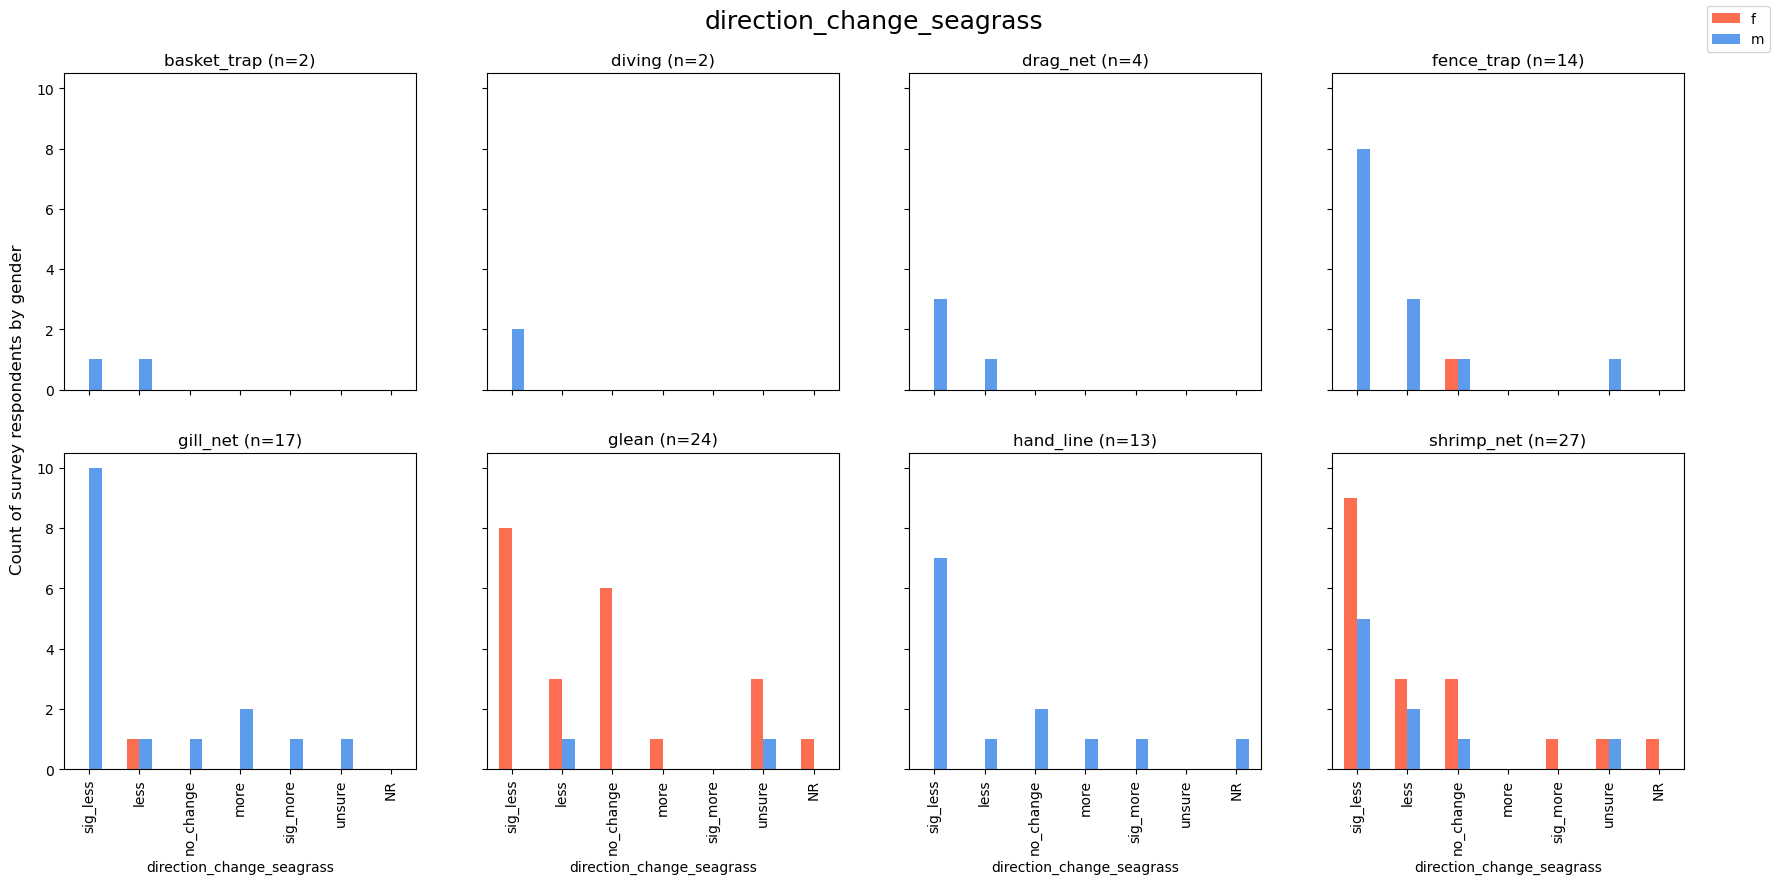

In [147]:
# specify the column
viz_col = 'direction_change_seagrass'

'''
'ccp', 'focal_resources','gender', 'birth_place', 'mar_status', 'ed_level', 'house_head', 'glean'
'access_credit_loans', 'community_participation','ccp_member', 'ccp_participation', 'decision_making_manag',
'decision_making_fish', 'change_seagrass', 'direction_change_seagrass','causes_change_seagrass', 'change_fish', 
'direction_change_resources','causes_change_resources', 'link_seagrass_resources','capacity_change_practice', 
'capacity_change_livelihood','capacity_organize', 'local_knowledge', 'agency_change_seagrass',
'agency_change_capture','action_seagrass', 'human_mang_seagrass', 'action_capture', 'human_mang_capture'
'''

# specify disaggregate column - this defines how data will be disaggregated within a given bar chart 
disagg_col = 'gender'

''' 
'gender','gear','ccp','none'
'''

# specify subplot column - this defines how data will be disaggregated across subplots
plot_col = 'gear'
'''
'ccp', 'gear', 'none'
'''

prop = False
plot(viz_col, disagg_col, plot_col, prop)

# Practice and Capture

In [148]:
print(len(df_prac_joined))
print(df_prac_joined.columns)

103
Index(['objectid', 'GlobalID', 'gear', '_gear_label', 'owner', 'gear_number',
       'practiced', 'quantity', 'unit', 'units_other', 'hours', 'value',
       'persons', 'ParentGlobalID', 'CreationDate', 'Creator', 'EditDate',
       'Editor', 'id', 'date', 'ccp', 'focal_resources', 'gender', 'age',
       'birth_place', 'mar_status', 'ed_level', 'house_head', 'glean',
       'electricity', 'fridge_freezer', 'fridge_freezer_num', 'water',
       'matress', 'matress_num', 'mobile_phone', 'mobile_phone_num',
       'smart_phone', 'smart_phone_num', 'fan', 'fan_num', 'tv', 'tv_num',
       'radio', 'radio_num', 'stove', 'stove_num', 'transport',
       'transport_num', 'floor', 'floor_other', 'wall', 'wall_other', 'roof',
       'roof_other', 'access_credit_loans', 'community_participation',
       'ccp_member', 'ccp_participation', 'decision_making_manag',
       'decision_making_fish', 'change_seagrass', 'direction_change_seagrass',
       'causes_change_seagrass', 'change_fish', 'di

In [149]:
# Group table by gear
df_prac= df_prac_joined[['objectid','ccp','gender','gear','quantity','unit','units_other','hours','value','persons']]


def fill_other(col, col_other):
    if col == "other":
        return col_other
    else:
        return col

def fill_blank(col, value):
    if pd.isna(col):
        return value
    else:
        return col

def cap_daily(units, quant):
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap = quant* units_cv
    else: 
        cap = None
    return cap

def cpue(cap_total, persons, hours):
    if persons is None or persons =="":
        persons = 1
    cpue = cap_total/(persons*hours)
    return cpue

def price_p_kg(value,quant):
    price_p_kg = value/quant
    return price_p_kg

# load units conversion sheet 
units_cnv_path ="/home/rthoms/ocean_dep/sur_B/units.csv"
units_cnv = pd.read_csv(units_cnv_path)

# convert to dict 
unit_dict= pd.Series(units_cnv.weight_kg.values,index=units_cnv.unit).to_dict()

# fill unit_other with values 
df_prac['unit_final']= df_prac.apply(lambda row: fill_other(row['unit'],row['units_other']), axis=1 ) 
df_prac['cap_daily_total'] = df_prac.apply(lambda row: cap_daily(row['unit_final'], row['quantity']), axis=1)
df_prac['persons_final'] = df_prac.apply(lambda row: fill_blank(row['persons'], 1), axis=1)
df_prac['cpue'] = df_prac.apply(lambda row: cpue(row['cap_daily_total'], row['persons_final'],row['hours'] ), axis=1)

# Group table by gear
df_prac_sum= df_prac.groupby(['gear']).agg({'objectid':'count', 'cap_daily_total': 'median', 'hours':'median', 'persons':'median', 'value':'median','cpue':'median'})
df_prac_sum.to_csv('practice_summary.csv')



Text(0, 0.5, 'Daily capture (kg)')

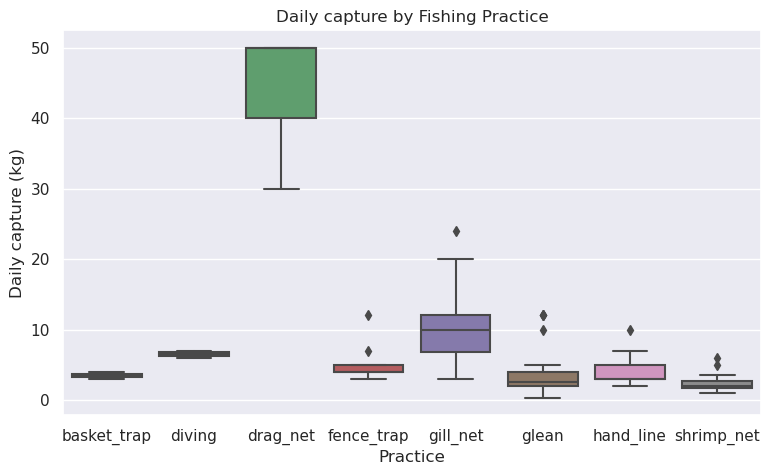

In [161]:
# DAILY CAPTURE BY FISHING PRACTICE

df_viz= df_prac.pivot_table(index=['objectid'], columns='gear', values='cap_daily_total')

# consider removing outlier 
#df_viz= df_prac[df_prac['objectid'] != 88].pivot_table(index=['objectid'], columns='gear', values='cap_daily_total')

sns.set(rc={"figure.figsize":(9, 5)})
#plot
sns.boxplot(data=df_viz)
# set title
plt.title('Daily capture by Fishing Practice')
# Set x-axis label
plt.xlabel('Practice')
# Set y-axis label
plt.ylabel('Daily capture (kg)')

Text(0, 0.5, 'Daily value (MTs)')

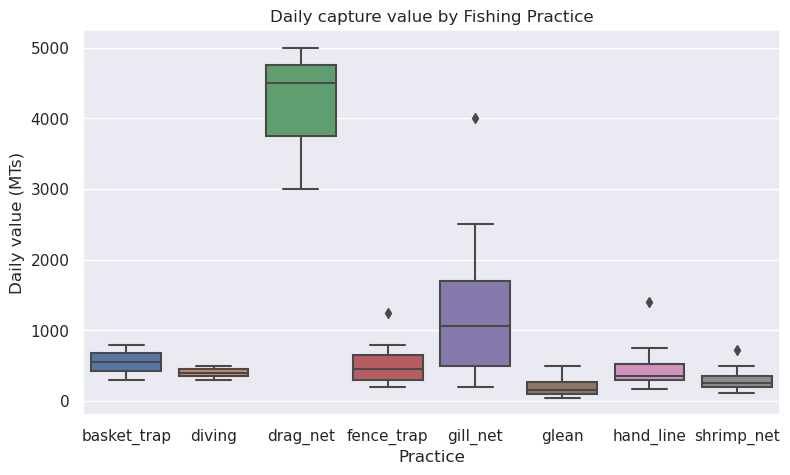

In [160]:
# DAILY CAPTURE VALUE BY FISHING PRACTICE

df_viz= df_prac.pivot_table(index=['objectid'], columns='gear', values='value')

# consider removing outlier 
#df_viz= df_prac[df_prac['objectid'] != 88].pivot_table(index=['objectid'], columns='gear', values='value')

sns.set(rc={"figure.figsize":(9, 5)})
#plot
sns.boxplot(data=df_viz)
# set title
plt.title('Daily capture value by Fishing Practice')
# Set x-axis label
plt.xlabel('Practice')
# Set y-axis label
plt.ylabel('Daily value (MTs)')

Text(0, 0.5, 'CPUE')

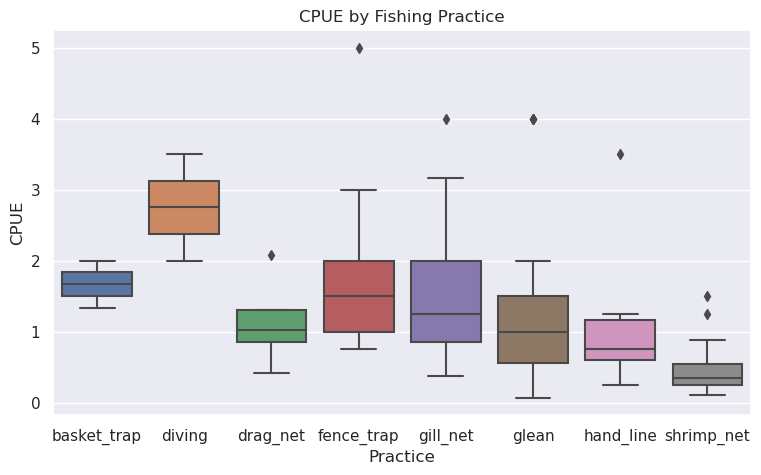

In [155]:
# CPUE BY FISHING PRACTICE

df_viz= df_prac.pivot_table(index=['objectid'], columns='gear', values='cpue')
df_viz.to_csv('temp.csv')


#plot
sns.boxplot(data=df_viz)
# set title
plt.title('CPUE by Fishing Practice')
# Set x-axis label
plt.xlabel('Practice')
# Set y-axis label
plt.ylabel('CPUE')

Text(0, 0.5, 'Price per Kg')

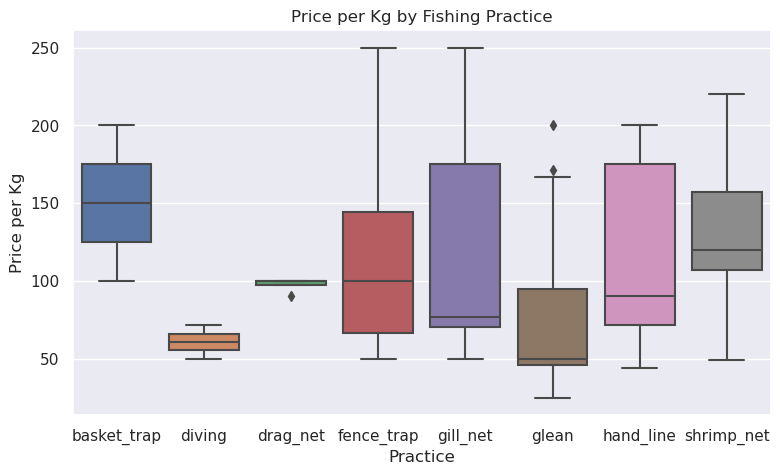

In [156]:
# PRICE PER KG BY FISHING PRACTICE

df_prac['price_p_kg'] = df_prac.apply(lambda row: price_p_kg(row['value'], row['cap_daily_total']), axis=1)

df_viz= df_prac.pivot_table(index=['objectid'], columns='gear', values='price_p_kg')

df_viz.to_csv('temp.csv')

#plot
sns.boxplot(data=df_viz)
# set title
plt.title('Price per Kg by Fishing Practice')
# Set x-axis label
plt.xlabel('Practice')
# Set y-axis label
plt.ylabel('Price per Kg')